In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda
from PIL import Image
import pandas as pd
from keras import backend as K
import imageio
from tensorflow import keras
from tensorflow.keras import layers
import os
from tensorflow.keras.preprocessing.image import load_img

In [2]:
#import the data

resolution = 200

#lst = [300K ,320K ,340K, 360K, 380K, 400K, 420K, 440K, 460K, 480K, 500K, 550K, 600K, 650K, 700K, 800K]
#Each class corresponds to a range of temperatures, defined by the above list:
#0: x < lst[0]
#1 - 15: lst[i] <= x < lst[i+1]
#16: lst[16] <= x

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

train_dir = 'D:\\Uni\\Year 4\\Research\\cGAN\\training\\'
validation_dir = 'D:\\Uni\\Year 4\\Research\\cGAN\\validation\\'

images =[]
one_hot = []


#The training data (lab images) was labelled using analytical means (and are stored in directories seperated by labels) 
#Extracting these images and their labels:
for i in classes:
    files = os.listdir('D:\\Uni\\Year 4\\Research\\cGAN\\training\\' + str(i))
    for file in files:
        
        onimg = load_img(train_dir + str(i) + '\\' + file, color_mode = "grayscale", target_size = (resolution, int(1.148*resolution)), interpolation = 'nearest')
        onimg = onimg.crop((int(0.1*resolution), 0, int(1.1*resolution), resolution))
        onimg = np.reshape(onimg, (resolution, resolution))
        onimg = onimg.astype(np.int16)
    
        images.append(onimg/12000)
        one_hot.append(keras.utils.to_categorical(i, 17))
        
imgs = np.concatenate(images)
labels = tf.convert_to_tensor(np.array(one_hot), 'float32')
imgs = tf.convert_to_tensor(np.reshape(imgs, (-1, resolution, resolution, 1)),'float32')
        
dataset = tf.data.Dataset.from_tensor_slices((imgs, labels))

dataset = dataset.repeat(30)

In [3]:
batch_size = 16
num_channels = 1
num_classes = 17
image_size = resolution
latent_dim = 500

dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
print(imgs.shape)
print(labels.shape)
dataset


(339, 200, 200, 1)
(339, 17)


<BatchDataset shapes: ((None, 200, 200, 1), (None, 17)), types: (tf.float32, tf.float32)>

In [4]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

517 18


In [5]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((resolution, resolution, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        MaxPooling2D(2,2),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        MaxPooling2D(2,2),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.

generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(5202),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((51, 51, 2)),
        layers.Conv2DTranspose(4, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(8, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (5, 5), activation="sigmoid"),
    ],
    name="generator",
)

In [6]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5202)              2694636   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 5202)              0         
_________________________________________________________________
reshape (Reshape)            (None, 51, 51, 2)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 102, 102, 4)       132       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 102, 102, 4)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 204, 204, 8)       520       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 204, 204, 8)       0 

In [7]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [8]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [9]:
cond_gan.fit(dataset, epochs = 20, steps_per_epoch = 339//batch_size, verbose = 1)

Epoch 1/20
21/21 [==============================] - 5s 113ms/step - g_loss: 0.7902 - d_loss: 0.6284
Epoch 2/20
21/21 [==============================] - 3s 124ms/step - g_loss: 1.3174 - d_loss: 0.3499
Epoch 3/20
21/21 [==============================] - 3s 138ms/step - g_loss: 2.4427 - d_loss: 0.1061
Epoch 4/20
21/21 [==============================] - 3s 158ms/step - g_loss: 3.5268 - d_loss: 0.0344
Epoch 5/20
21/21 [==============================] - 4s 182ms/step - g_loss: 3.6539 - d_loss: 0.0315
Epoch 6/20
21/21 [==============================] - 5s 218ms/step - g_loss: 2.9525 - d_loss: 0.0890
Epoch 7/20
21/21 [==============================] - 6s 284ms/step - g_loss: 1.5569 - d_loss: 0.3465
Epoch 8/20
21/21 [==============================] - 7s 350ms/step - g_loss: 0.9262 - d_loss: 0.7119
Epoch 9/20
21/21 [==============================] - 10s 502ms/step - g_loss: 0.5891 - d_loss: 0.9181
Epoch 10/20
21/21 [==============================] - 13s 633ms/step - g_loss: 0.5379 - d_loss: 0.91

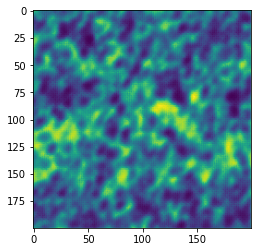

In [18]:
trained_gen = cond_gan.generator

random_latent_vector = tf.random.normal(shape=(1, latent_dim))
label = keras.utils.to_categorical([8], 17)
noise_and_labels = tf.concat([random_latent_vector, label], 1)

fake_image = trained_gen.predict(noise_and_labels)

plt.imshow(fake_image.reshape(200,200))